In [21]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(stringr)
options(warn=-1)

source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [9]:
val=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","deeppink","darkseagreen","black","#fdbb84","orange")
plot_surv <-function(fit,tmp,title="",vals=val,legend="top"){
    ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",palette=vals,legend=legend,
                  ggtheme = theme_survminer(
                 font.main = c(26, "bold", "darkblue"),
                 font.submain = c(25, "bold.italic", "purple"),
                 font.legend=14,
                      pval.size=20,
                 font.caption = c(24, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(22, "plain", "darkgreen")))

}

### New Overlapping Rules:
- t_15_17 excludes : additions ; WT1 ; chr_splicing_1
- inv_16 excludes : additions ; WT1 ; chr_splicing_1
- t_8_21 excludes : additions ; WT1 ; chr_splicing_1
- t_11 excludes : additions ; WT1 ; chr_splicing_1
- t_6_9 excludes : WT1
- inv_3 excludes :additions ; chr_splicing_1
- additions excludes : t_15_17 ; inv_16 ; t_8_21 ; t_11 ; inv_3 ; TP53 complex with pluses without deletions ; NPM1 ; DNMT3A_IDH1_2 ; WT1
- TP53_complex excludes : additions if TP53 complex with pluses without deletions 
; DNMT3A_IDH1_2 ; WT1 ; chr_splicing_1
- NPM1 excludes : additions ; DNMT3A_IDH1_2 ; WT1; chr_splicing_1
- CEBPA_bi excludes : DNMT3A_IDH1_2 ; WT1 ; chr_splicing_1
- DNMT3A_IDH1_2 excludes : additions ; TP53_complex ; NPM1 ; CEBPA_bi
- WT1 excludes : t_15_17 ; inv_16 ; t_8_21 ; t_11 ; t_6_9 ; additions ; TP53_complex ; NPM1 ; CEBPA_bi 
- chr_splicing_multiple excludes : nothing
- chr_splicing_1 excludes : t_15_17 ; inv_16 ; t_8_21 ; t_11 ; inv_3 ; TP53_complex ; NPM1 ; CEBPA_bi


In [10]:
df_w_correlates <- read.table("df_final_full_component_ITD.tsv")
df_final <- read.table("df_final_full_component_ITD.tsv")
col_list <- c("t_15_17","inv_16","t_8_21","t_8_21_ITD","t_11","t_6_9","t_6_9_ITD","inv_3","additions","TP53_complex","NPM1","NPM1_ITD","CEBPA_bi","CEBPA_bi_ITD","DNMT3A_IDH1_2","DNMT3A_IDH1_2_ITD",
              "WT1","WT1_ITD","chr_splicing_multiple","chr_splicing_1","not_assigned","not_assigned_ITD","no_events")

In [12]:
pdf(file="graphs/component_repartition.pdf",width=12,height=18)
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
df_tmp <- setNames(data.frame(matrix(ncol = length(col_list), nrow = length(col_list))), gsub("full_component_","",col_list))
rownames(df_tmp) <- gsub("full_component_","",col_list)
for (col in cols_component){
    for (col_bis in cols_component){
        df_tmp[gsub("full_component_","",col),gsub("full_component_","",col_bis)] <- ifelse(is.null(dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1]),0,dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1])
        }}

set_notebook_plot_size(20,12)
get_lower_tri<-function(cormat){
cormat[upper.tri(cormat)] <- NA
return(cormat)
}
# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
cormat[lower.tri(cormat)]<- NA
return(cormat)
}
upper_tri <- get_upper_tri(as.matrix(df_tmp))
melted_cormat <- melt(upper_tri, na.rm = TRUE)
melted_cormat <- cbind(melted_cormat, value_bis=0)
for (col in unique(melted_cormat$Var1)){
    melted_cormat[melted_cormat$Var1==col,]$value_bis <- 100*melted_cormat[melted_cormat$Var1==col,]$value / melted_cormat[melted_cormat$Var1==col & melted_cormat$Var2==col,]$value
    }
tmp <- t(data.frame(table(df_final$final_component)))
rownames(tmp) <- c("Final Component (HDP)","Num of Patients")
tmp <- t(data.frame(table(df_w_correlates$overlap)))
rownames(tmp) <- c("Overlap","Num of Patients")
tmp
ggplot(melted_cormat, aes(Var2, Var1, fill = value_bis))+
geom_tile(color = "white")+
scale_fill_gradient2(low = "#0072B2", high = "#009E73", mid = "#BFBFBF", 
  space = "Lab", 
name="Proportion of overlapping patients (%)") +
theme_minimal()+ # minimal theme
theme(axis.text.x = element_text(angle = 45, vjust = 1, 
size = 8, hjust = 1),axis.text.y = element_text( vjust = 1, 
size = 8, hjust = 1))+
coord_fixed()+
xlab("Component")+ylab("Component")+
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
panel.grid.major = element_blank(),
panel.border = element_blank(),
panel.background = element_blank(),
axis.ticks = element_blank(),
legend.justification = c(2, 0),
#legend.position = c(0.6, 0.7),
legend.direction = "horizontal",
plot.title=element_text(size=25,face="bold",hjust=0.5))+
guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
            title.position = "top", title.hjust = 0.5))+
ggtitle("Component Repartition")
dev.off()

Overlap,0,1
Num of Patients,1768,357


pdf 
  2

# Plot Showing survival of the patients in the component

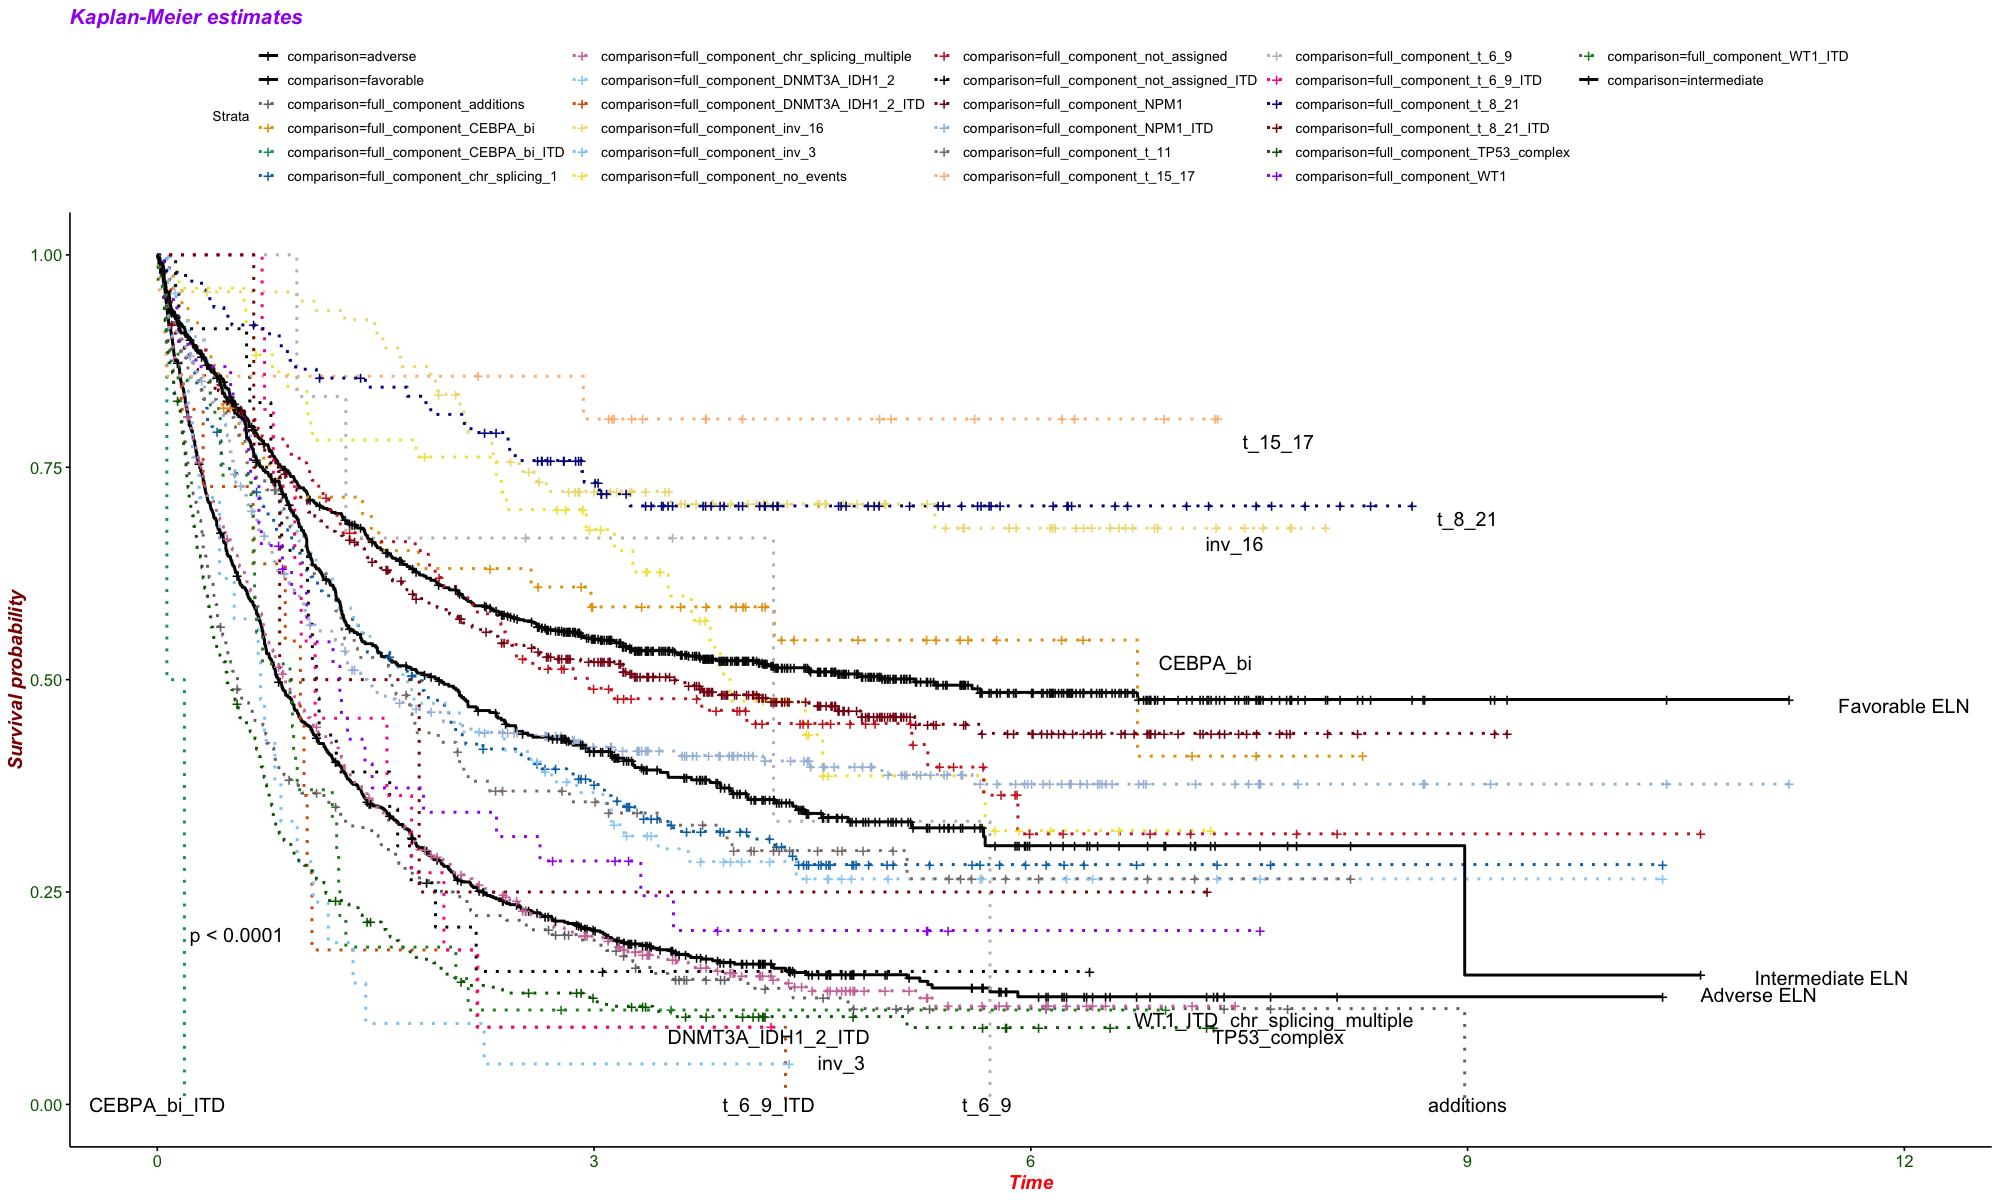

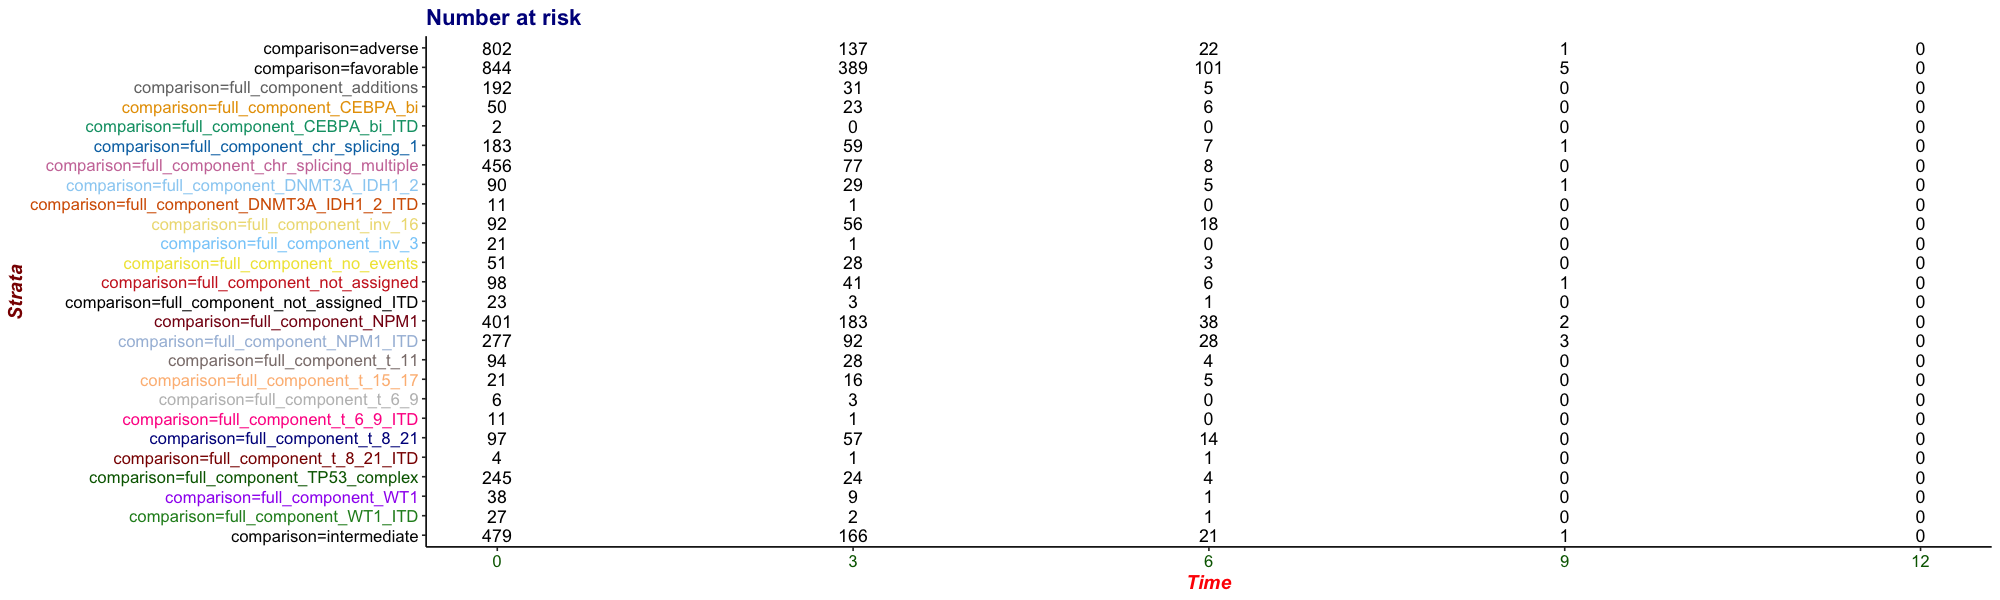

In [15]:
# pdf(file="graphs/eln_comp_surv.pdf",width=20,height=12)
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
tmp <- NULL
for (comp in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp1$comparison <- comp
    tmp <- rbind(tmp,tmp1)
    }

tmp1 <- df_w_correlates
tmp1$comparison <- ifelse(tmp1$eln_2017==1,"adverse",
                          ifelse(tmp1$eln_2017==2,"intermediate","favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",palette=colors,linetype=c(1,1,rep(3,23),1),
                  ggtheme = theme_survminer(
                 font.main = c(16, "bold", "darkblue"),
                 font.submain = c(15, "bold.italic", "purple"),
                 font.caption = c(14, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(12, "plain", "darkgreen")))

set_notebook_plot_size(20,12)
p$plot + ggplot2::annotate("text", 
                                x = c(0,7,4.2,4.2,4.7,5.7,7.7,9,8,11,11.5,12,7.2,7.4,9,7.7), y = c(0,0.1,0,0.08,0.05,0,0.08,0,0.1,0.13,0.15,0.47,0.52,0.66,0.69,0.78),
                                label = c("CEBPA_bi_ITD","WT1_ITD","t_6_9_ITD","DNMT3A_IDH1_2_ITD","inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse ELN","Intermediate ELN",
                                          "Favorable ELN","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)
set_notebook_plot_size(20,6)
p$table
# dev.off()

# COMPARISON CLINICAL AND DEMOGRAPHICAL CORRELATES

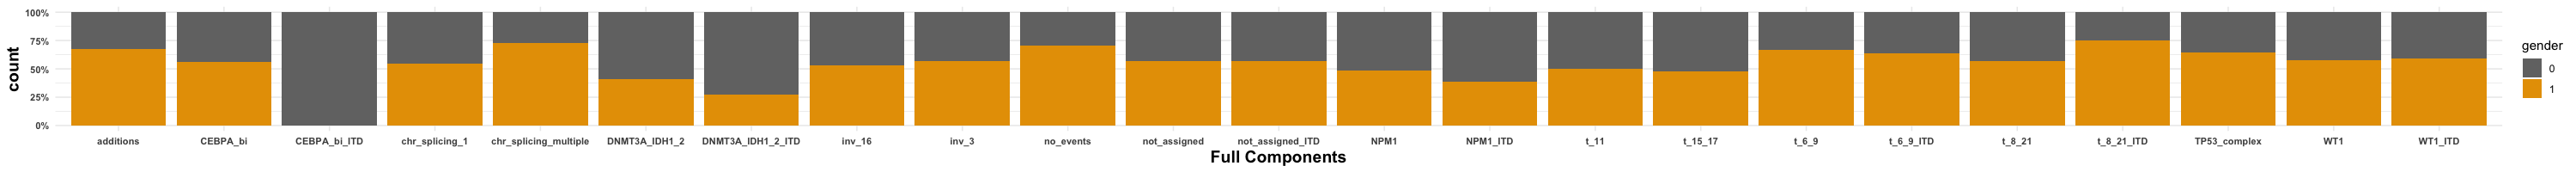

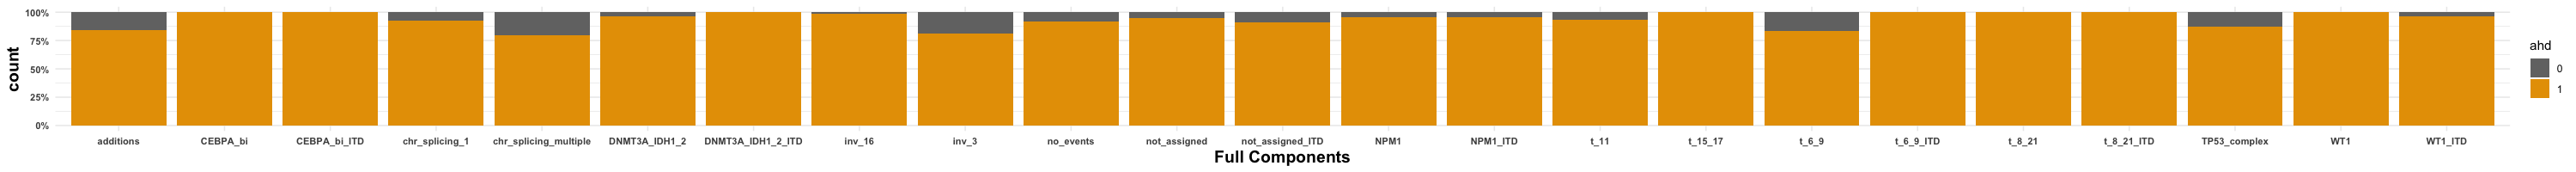

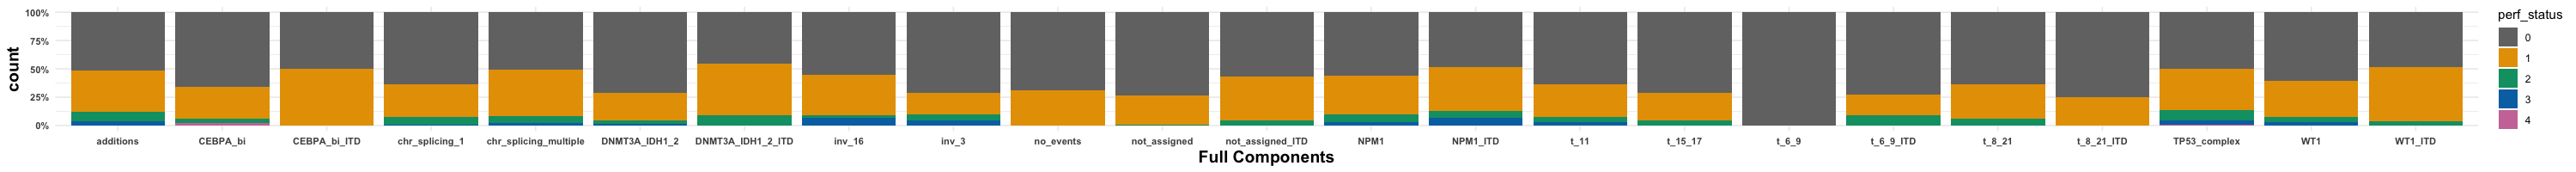

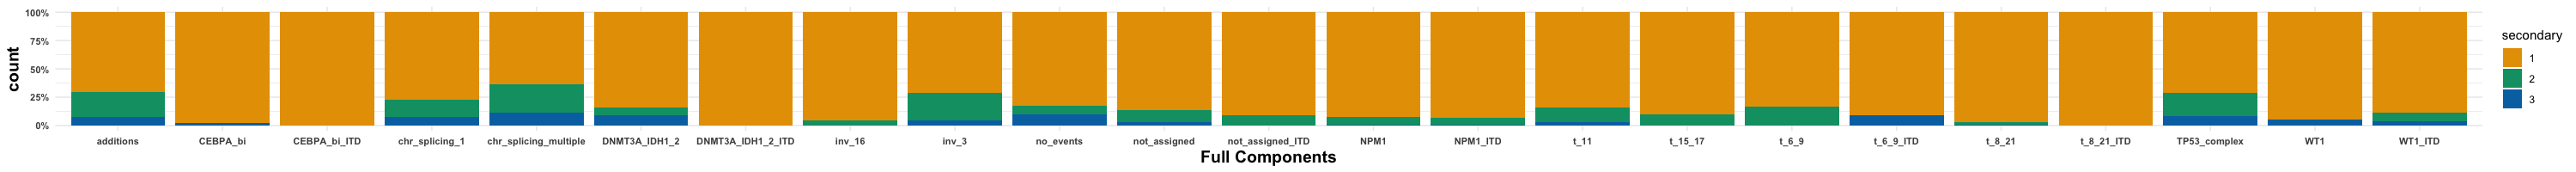

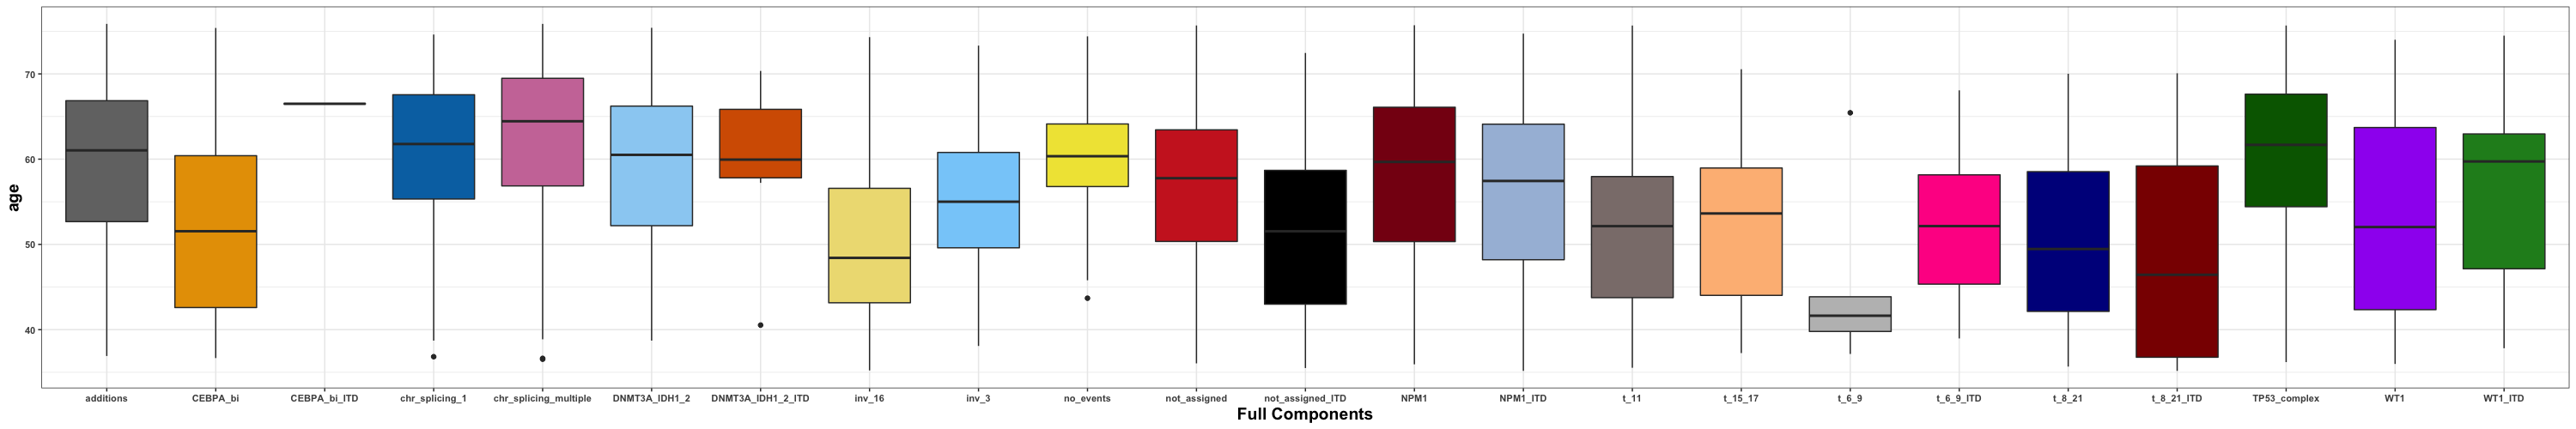

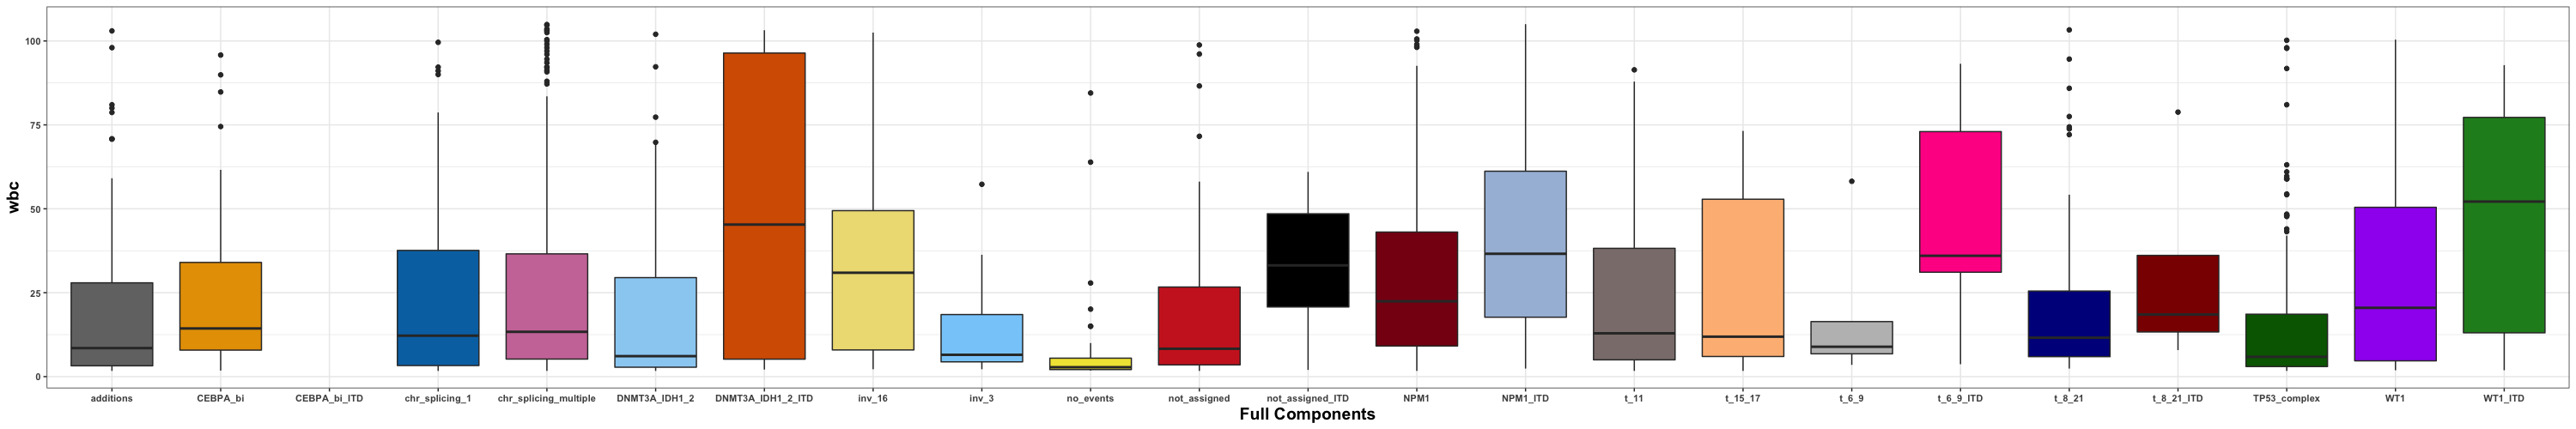

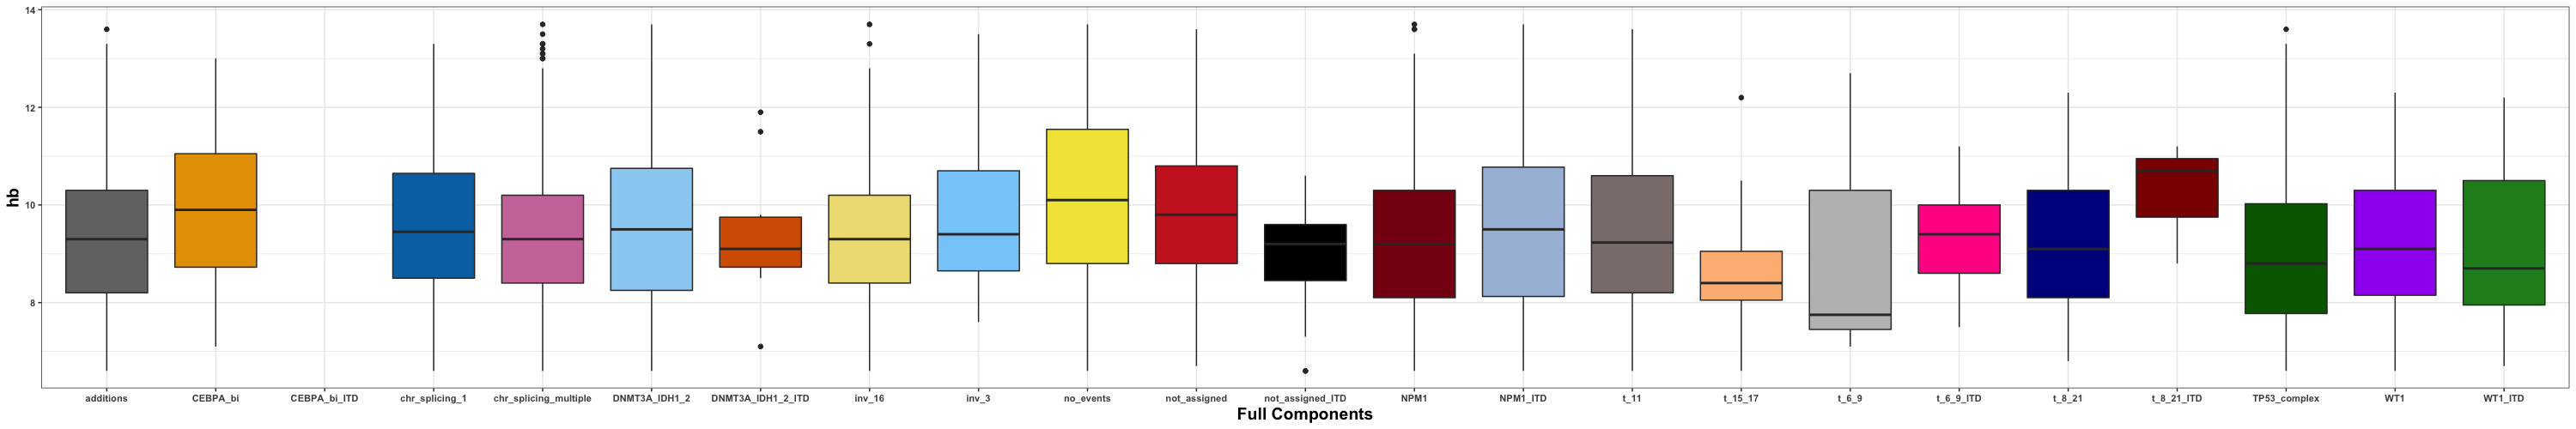

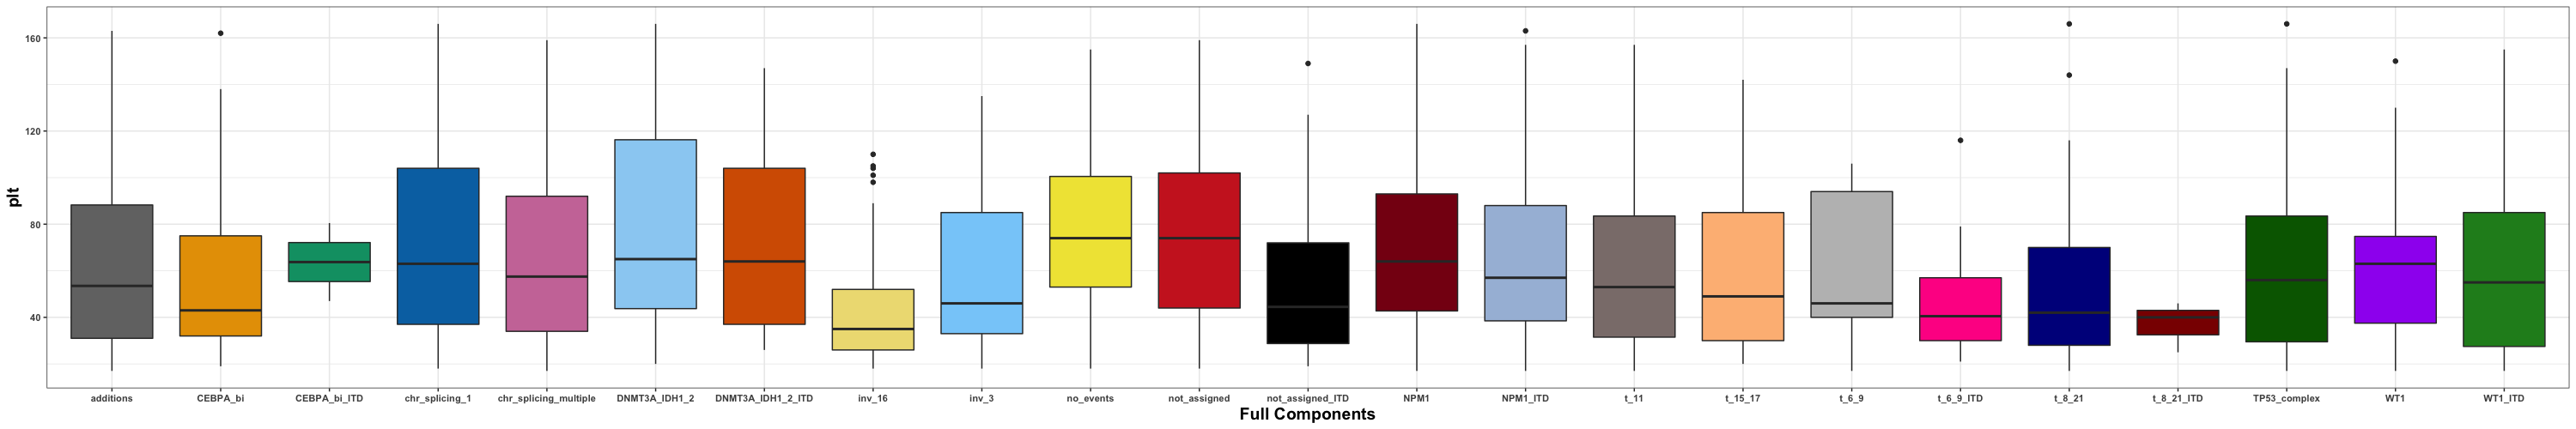

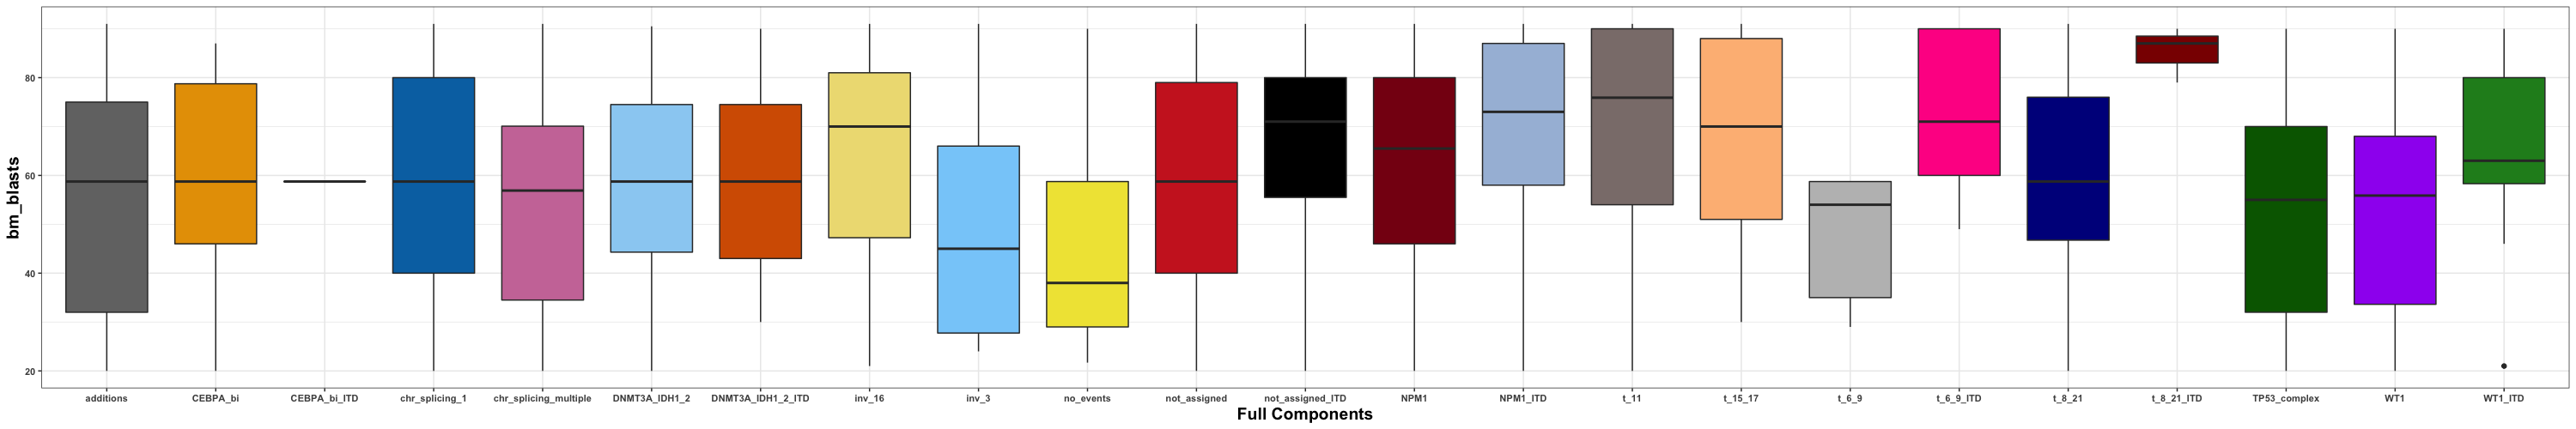

In [121]:
# pdf(file="graphs/comparison_components_ITD.pdf",width=30,height=5)
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
binary_correlates <- c("gender","ahd","perf_status","secondary")

continuous_correlates <- c("age","wbc","hb","plt","bm_blasts")
set_notebook_plot_size(30,2)
# pdf(file="graphs/comparison_components_ITD.pdf",width=30,height=5)
v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")
tmp <- NULL
for (comp in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp1$comparison <- str_remove(comp,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
for (col in binary_correlates){
p <- ggplot(tmp, aes(factor(comparison), fill = factor(tmp[,col]))) + 
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent)+
  xlab("Full Components")+scale_fill_manual(values = v)+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=8,face="bold"),axis.title=element_text(size=14,face="bold"))+
  labs(fill=col)
    plot(p)
}
set_notebook_plot_size(30,5)
for (col in continuous_correlates){
    p <- ggplot(tmp,aes(x=factor(comparison),y=tmp[,col],fill=fill_pal)) +
    geom_boxplot() + 
    theme1+
    ylab(col)+xlab("Full Components")+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=8,face="bold"),axis.title=element_text(size=14,face="bold"))+
    scale_y_continuous(limits = quantile(tmp[,col], c(0.1, 0.9),na.rm = T))+
    scale_fill_manual(values=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen"),limits=levels(tmp$fill_pal))+theme(legend.position = "none")
    # set ymin to 0 (Elli's request)
    suppressWarnings(plot(p))
    
}




# dev.off()

Order of Components : 
t_15_17  , inv_16  , t_8_21  , t_11  , t_6_9  , inv_3  , additions  , TP53_complex  , NPM1  , CEBPA_bi  , DNMT3A_IDH1_2  , WT1  , chr_splicing_multiple  , chr_splicing_1  , not_assigned  , no_events  ,

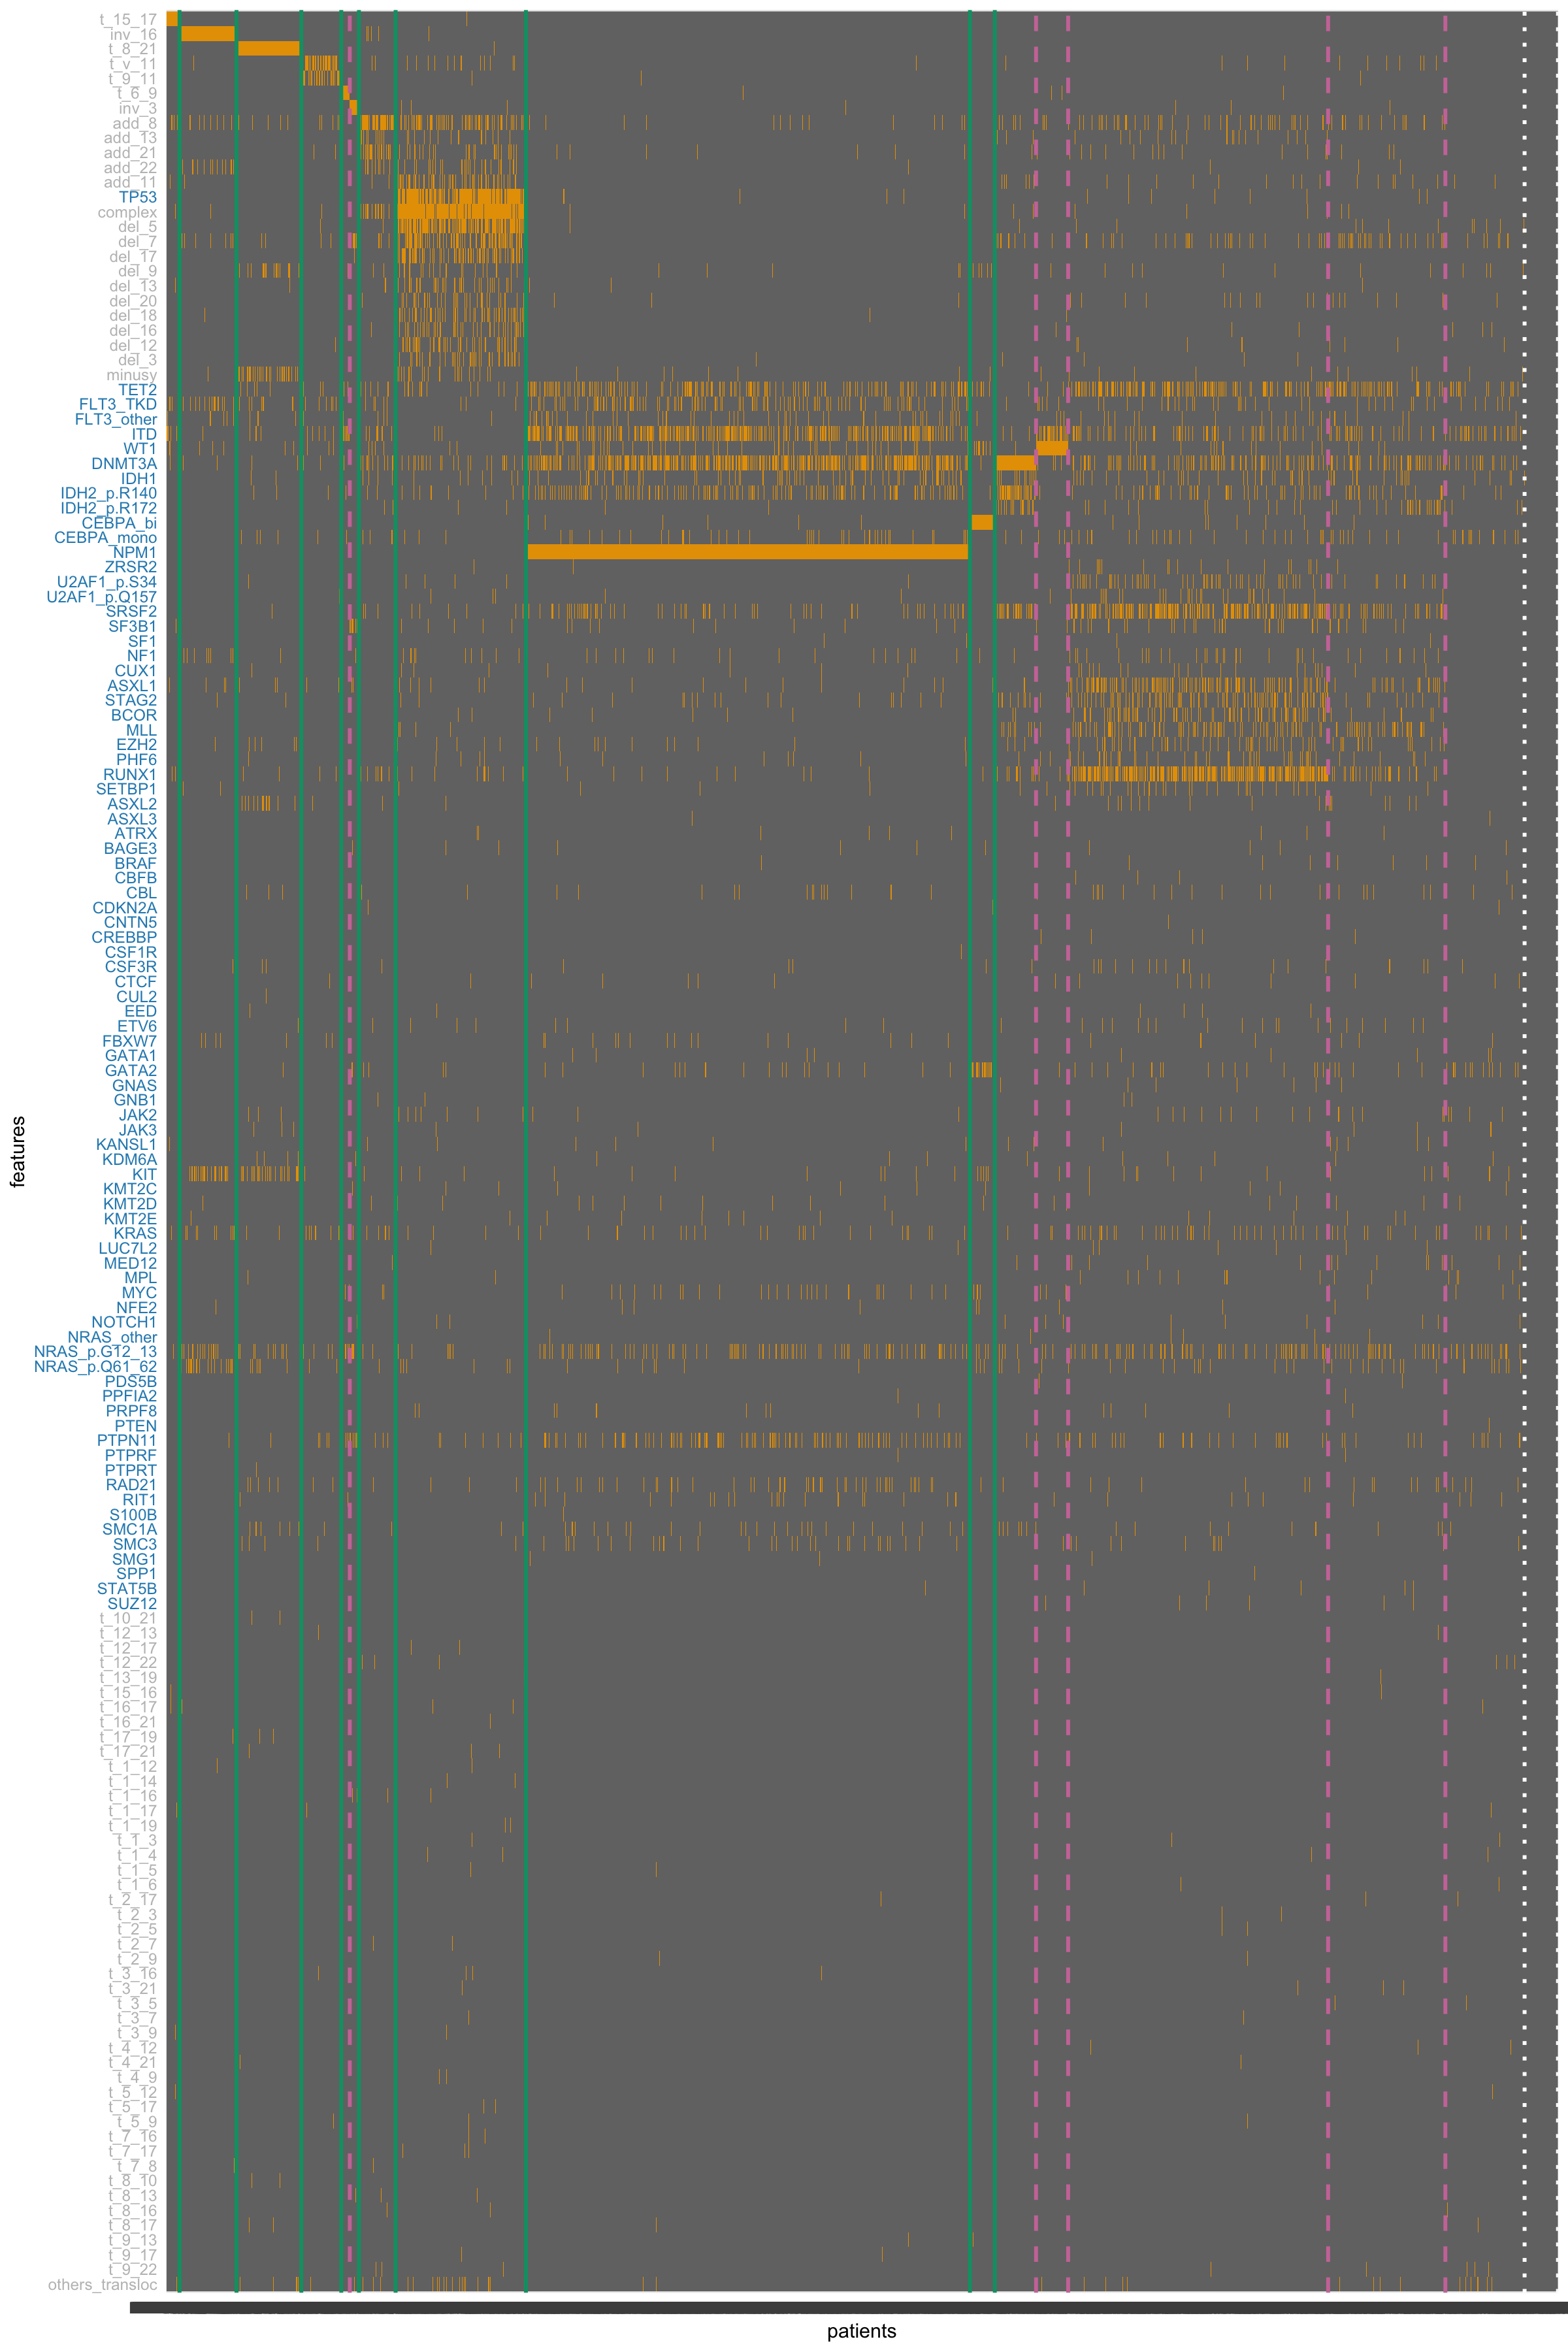

In [17]:
cols_to_keep = c(5:158,169)
splicing <-  c("ZRSR2", "U2AF1_p.S34","U2AF1_p.Q157", "SRSF2", "SF3B1", "SF1", "NF1", "CUX1")
chromatin <- c("ASXL1", "STAG2", "BCOR", "MLL", "EZH2", "PHF6")
transcriptor <- c("RUNX1","SETBP1") 
factors <- c(splicing,chromatin,transcriptor)

features_cols <- colnames(df_final[,5:158])
tmp_all <- df_final[,cols_to_keep][order(df_final[,cols_to_keep]$final_component_numeric),]
transp_df_all <-(as.data.frame(t(tmp_all)))
transp_df_all$features <- rownames(transp_df_all)
transp_df_all <- transp_df_all[! row.names(transp_df_all) == "final_component_numeric",]
col_order <- c("t_15_17","inv_16","t_8_21","t_v_11","t_9_11","t_6_9","inv_3","add_8","add_13","add_21","add_22","add_11","TP53","complex","del_5","del_7","del_17","del_9","del_13","del_20","del_18","del_16","del_12","del_3","minusy",
              "TET2","FLT3_TKD","FLT3_other","ITD","WT1","DNMT3A","IDH1","IDH2_p.R140","IDH2_p.R172","CEBPA_bi","CEBPA_mono","NPM1",factors)
col_order <- c(col_order,setdiff(features_cols,col_order))
col_order <- rev(col_order)
transp_df_all <- transp_df_all[col_order,]
melt.data_all<-melt(transp_df_all,id.vars ="features", variable_name=colnames(transp_df_all))
melt.data_all$features <- factor(melt.data_all$features,levels=col_order)  # rev because otherwise the first are at the bottom
gen <- colnames(df_final[,c(5:88)])

cyto <- colnames(df_final[,c(89:158)])
                           
pal <- ifelse(is.element(melt.data_all$features,gen),"#2b8cbe","#BFBFBF") 
options(repr.plot.res = 200)
set_notebook_plot_size(12, 18)
col_sep <- tabulate(df_final[,cols_to_keep]$final_component_numeric)   ## to separate by component

cat("Order of Components :","\n")
cat(paste(unique(df_final[order(df_final[,cols_to_keep]$final_component_numeric),]$final_component)," ,"))
# plot the heatmap
ggplot(melt.data_all, aes(variable,features)) +  
geom_raster(aes(fill = factor(value)), show.legend = FALSE) +
scale_fill_manual(values = c("0" = "grey45", "1" = "#e79f00")) +
#geom_vline(xintercept = cumsum(col_sep)[1:9] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[c(1,2,3,4,6,7,8,9,10)] + 0.5, col = "#009E73", linetype = 1, size = 1) +
geom_vline(xintercept = cumsum(col_sep)[c(5,11,12,13,14)] + 0.5, col = "#CC79A7", linetype = 2, size = 1) +
geom_vline(xintercept = cumsum(col_sep)[c(15,16)] + 0.5, col = "white", linetype = 3, size = 1) +
theme(axis.text.y = element_text(colour = pal))+
labs(x = 'patients')